_Lambda School Data Science — Model Validation_

# Select models and parameters

Objectives
- Hyperparameter optimization
- Model selection

Today we'll use this process:

## "A universal workflow of machine learning"

_Excerpt from Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning_
 
**1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

**2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

**3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

**4. Develop a first model that does better than a basic baseline:** a model with statistical power.

**5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

**6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

Iterate on feature engineering: add new features, or remove features that don’t seem to be informative. Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.


## 1. Define the problem at hand and the data on which you'll train

We'll apply the workflow to a [project from _Python Data Science Handbook_](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic) by Jake VanderPlas:

> **Predicting Bicycle Traffic**

> As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

> We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

> Let's start by loading the two datasets, indexing by date:

So this is a regression problem, not a classification problem. We'll define the target, choose an evaluation metric, and choose models that are appropriate for regression problems.




### Load data

In [1]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

import pandas as pd

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, 
                      infer_datetime_format=False)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

In [2]:
# Make a feature for yesterday's total
daily['Total_yesterday'] = daily.Total.shift(1)

daily = daily.drop(index=daily.index[0])

### First fast look at the data
- What's the shape?
- What's the date range?
- What's the target and the features?

In [3]:
daily.shape

(1063, 8)

In [4]:
daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,3537.0,0,0,0,211,78,19,2142.0


Target
- Total : Daily total number of bicycle trips across Seattle's Fremont Bridge

Features
- Date (index) : from 2012-10-04 to 2015-09-01
- Total_yesterday : Total trips yesterday
- PRCP : Precipitation (1/10 mm)
- SNOW : Snowfall (1/10 mm)
- SNWD : Snow depth (1/10 mm)
- TMAX : Maximum temperature (1/10 Celsius)
- TMIN : Minimum temperature (1/10 Celsius)
- AWND : Average daily wind speed (1/10 meters per second)

## 2. Choose how you’ll measure success on your problem.

Which metrics will you monitor on your validation data?

This is a regression problem, so we need to choose a regression [metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).



I'll choose mean absolute error.



In [9]:
from sklearn.metrics import mean_absolute_error

## 3. Determine your evaluation protocol 

We're doing model selection, hyperparameter optimization, and performance estimation. So generally we have two ideal [options](https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg) to choose from:

- 3-way holdout method (train/validation/test split)
- Cross-validation with independent test set

I'll choose cross-validation with independent test set. Scikit-learn makes cross-validation convenient for us!

Specifically, I will use random shuffled cross validation to train and validate, but I will hold out an "out-of-time" test set, from the last 100 days of data:





In [11]:
train = daily[:-100]
test = daily[-100:]

In [13]:
X_train = train.drop(columns='Total')
y_train = train['Total']

X_test = test.drop(columns='Total')
y_test = test['Total']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 7), (963,), (100, 7), (100,))

In [23]:
X_train.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,0,0,189,83,65,3521.0
2012-10-05,0,0,0,217,89,57,3475.0
2012-10-06,0,0,0,239,78,51,3148.0
2012-10-07,0,0,0,239,78,13,2006.0
2012-10-08,0,0,0,211,78,19,2142.0


## 4. Develop a first model that does better than a basic baseline

### Look at the target's distribution and descriptive stats

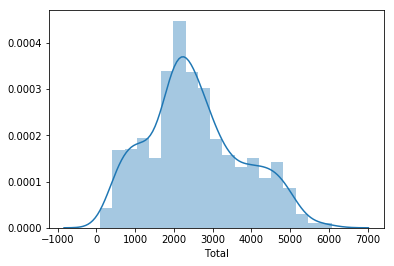

In [17]:
import seaborn as sns
sns.distplot(y_train);

In [19]:
y_train.describe()

count     963.000000
mean     2534.329180
std      1224.065027
min        98.000000
25%      1755.000000
50%      2381.000000
75%      3317.500000
max      6088.000000
Name: Total, dtype: float64

### Basic baseline 1

In [22]:
import numpy as np
y_pred = np.full(y_train.shape, y_train.mean())
mean_absolute_error(y_train, y_pred)

980.8981106765484

### Basic baseline 2
Let's just assume the same weather as yesterday

In [24]:
y_pred = X_train.Total_yesterday
mean_absolute_error(y_train, y_pred)

708.061266874351

### First model that does better than a basic baseline

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(), X_train, y_train,
                       scoring='neg_mean_absolute_error', cv=3,
                       return_train_score=True, 
                       return_estimator=True)

# Renaming the internal parameters to our nomenclature,
# and casting as a dataframe for easier visualization
pd.DataFrame(scores).rename(columns={'test_score':'val_score'})

,fit_time,score_time,estimator,val_score,train_score
0,0.006146,0.002572,"LinearRegression(copy_X=True, fit_intercept=Tr...",-555.186275,-619.509206
1,0.004199,0.001707,"LinearRegression(copy_X=True, fit_intercept=Tr...",-651.126513,-583.427702
2,0.004158,0.001991,"LinearRegression(copy_X=True, fit_intercept=Tr...",-615.965800,-589.341301


In [30]:
# Note that the 'estimator' entry in the output is the actual model
# object, fit to the data and ready for querying.
scores

{'fit_time': array([0.00614595, 0.00419879, 0.00415802]),
 'score_time': array([0.00257206, 0.00170708, 0.00199127]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False)),
 'test_score': array([-555.18627454, -651.12651327, -615.96579978]),
 'train_score': array([-619.50920623, -583.42770209, -589.3413007 ])}

In [32]:
# Significantly better than qust guessing yesterday's weather
scores['test_score'].mean()

-607.4261958631805

In [36]:
for i, model in enumerate(scores['estimator']):
    coefficients = model.coef_
    intercept = model.intercept_
    feature_names = X_train.columns
    
    print(f'Model from cross validation fold #{i}')
    print(f'Intercept: {intercept}')
    for name, coef in zip(feature_names, coefficients):
        print(f'{name:20}{coef}')
    print()

Model from cross validation fold #0
Intercept: 566.7766337283692
PRCP                -3.5251030638730323
SNOW                -0.0820286596945395
SNWD                -12.045027424625347
TMAX                9.475237800217549
TMIN                -4.6077746025385755
AWND                -2.74519066205123
Total_yesterday     0.4173602229456304

Model from cross validation fold #1
Intercept: 671.9064515706045
PRCP                -2.7722529441910893
SNOW                -0.0009947361806794965
SNWD                20.800687633734636
TMAX                8.804948207804252
TMIN                -3.7413861191474598
AWND                -6.108300188094694
Total_yesterday     0.4050743112376638

Model from cross validation fold #2
Intercept: 465.84525362296336
PRCP                -2.8761959151874668
SNOW                -0.01643158633711839
SNWD                -8.809695835488693
TMAX                10.419441168835974
TMIN                -5.862868464913562
AWND                -2.3989913411104125
Total_yeste

In [37]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     230.2
Date:                Wed, 30 Jan 2019   Prob (F-statistic):          4.80e-200
Time:                        10:02:41   Log-Likelihood:                -7736.8
No. Observations:                 963   AIC:                         1.549e+04
Df Residuals:                     955   BIC:                         1.553e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             571.7691     93.165     

/anaconda3/envs/sandbox/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 5. Develop a model that overfits. 

"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —Chollet

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

Diagram source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

### Polynomial Regression?

In [38]:
# Copied from cell 10 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [39]:
for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 8 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday']


2 degree polynomial has 36 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP TMAX', 'PRCP TMIN', 'PRCP AWND', 'PRCP Total_yesterday', 'SNOW^2', 'SNOW SNWD', 'SNOW TMAX', 'SNOW TMIN', 'SNOW AWND', 'SNOW Total_yesterday', 'SNWD^2', 'SNWD TMAX', 'SNWD TMIN', 'SNWD AWND', 'SNWD Total_yesterday', 'TMAX^2', 'TMAX TMIN', 'TMAX AWND', 'TMAX Total_yesterday', 'TMIN^2', 'TMIN AWND', 'TMIN Total_yesterday', 'AWND^2', 'AWND Total_yesterday', 'Total_yesterday^2']


3 degree polynomial has 120 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP TMAX', 'PRCP TMIN', 'PRCP AWND', 'PRCP Total_yesterday', 'SNOW^2', 'SNOW SNWD', 'SNOW TMAX', 'SNOW TMIN', 'SNOW AWND', 'SNOW Total_yesterday', 'SNWD^2', 'SNWD TMAX'

### Validation curve (with Polynomial Regression)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html

> Validation curve. Determine training and test scores for varying parameter values. This is similar to grid search with one parameter.

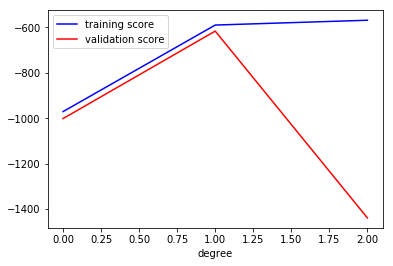

In [40]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

degree = [0, 1, 2]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree');

### Grid Search (with Polynomial Regression)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': [0,1,2,3]
}

gridsearch = GridSearchCV(PolynomialRegression(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1026.3529857047195, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1001.6149251268913, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-927.0707048650538, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-555.1862745374102, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-651.1265132746228, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-615.9657997775082, total=   0.0s
[CV] polynomialfeatures__degree=2 ......................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [47]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.008233,0.000141,0.003045,0.000620,1,{'polynomialfeatures__degree': 1},-555.186275,-651.126513,-615.965800,-607.426196,39.630174,1,-619.509206,-583.427702,-589.341301,-597.426070,15.800661
0,0.006812,0.001097,0.002212,0.000560,0,{'polynomialfeatures__degree': 0},-1026.352986,-1001.614925,-927.070705,-985.012872,42.197661,2,-968.880368,-970.755413,-999.896701,-979.844161,14.199935
2,0.011082,0.001604,0.003391,0.001019,2,{'polynomialfeatures__degree': 2},-7553.673677,-1439.191570,-644.122834,-3212.329360,3086.906373,3,-595.089615,-568.150803,-565.761032,-576.333816,13.298189
3,0.013211,0.003104,0.004544,0.000887,3,{'polynomialfeatures__degree': 3},-2658.143426,-97989.955055,-1847.898741,-34165.332407,45132.035675,4,-565.787903,-663.520092,-576.085578,-601.797858,43.846218


### Random Forest?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [48]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=20)

scores = cross_validate(model, X_train, y_train,
                       scoring='neg_mean_absolute_error',
                       cv=3, return_train_score=True,
                       return_estimator=True)
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.337283,0.016486,"(DecisionTreeRegressor(criterion='mse', max_de...",-560.114545,-247.878722
1,0.282202,0.014399,"(DecisionTreeRegressor(criterion='mse', max_de...",-639.362976,-222.719568
2,0.288726,0.014874,"(DecisionTreeRegressor(criterion='mse', max_de...",-639.006226,-225.679533


In [50]:
scores['test_score'].mean()

-612.8279160225942

### Validation Curve (with Random Forest)

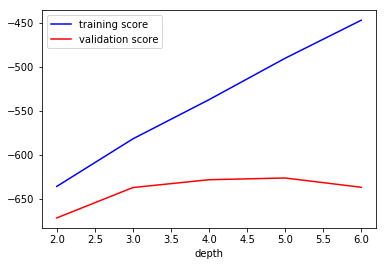

In [51]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

### Grid Search (with Random Forest)

In [53]:
%%time

param_grid = {
    'n_estimators':[100,200],
    'max_depth':[4,5],
    'criterion':['mse','mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True, verbose=10)
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-553.4565491797731, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-642.3874635887863, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-626.3061990003621, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-550.8200594649268, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-641.1974878357842, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-623.7843184381495, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-541.4504390905468, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-636.8694613903333, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-629.8349525479217, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-544.4331700864603, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-638.2422629263306, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-626.0790779969573, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-543.3381464174455, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-634.1614641744547, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-617.0409190031153, total=   1.1s
[CV] criterion=mae, max_depth=4, n_estimators=200 ....................
[CV]  criterion=mae, m

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   25.3s finished


CPU times: user 28.4 s, sys: 570 ms, total: 28.9 s
Wall time: 29.8 s


In [54]:
results= pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from grid search of 8 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,2.498138,0.088809,0.01934,0.001241,mae,5,200,"{'criterion': 'mae', 'max_depth': 5, 'n_estima...",-537.724112,-637.279439,-611.712064,-595.571872,42.215283,1,-516.304143,-474.442348,-484.807243,-491.851245,17.801048


## FEATURE ENGINEERING!

Jake VanderPlas demonstrates this feature engineering: 
https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

In [55]:
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic


# patterns of use generally vary from day to day; 
# let's add binary columns that indicate the day of the week:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    X_train[day] = (X_train.index.dayofweek == i).astype(float)


    
# we might expect riders to behave differently on holidays; 
# let's add an indicator of this as well:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
X_train = X_train.join(pd.Series(1, index=holidays, name='holiday'))
X_train['holiday'].fillna(0, inplace=True)



# We also might suspect that the hours of daylight would affect 
# how many people ride; let's use the standard astronomical calculation 
# to add this information:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

X_train['daylight_hrs'] = list(map(hours_of_daylight, X_train.index))



# temperatures are in 1/10 deg C; convert to C
X_train['TMIN'] /= 10
X_train['TMAX'] /= 10

# We can also calcuate the average temperature.
X_train['Temp (C)'] = 0.5 * (X_train['TMIN'] + X_train['TMAX'])



# precip is in 1/10 mm; convert to inches
X_train['PRCP'] /= 254

# In addition to the inches of precipitation, let's add a flag that 
# indicates whether a day is dry (has zero precipitation):
X_train['dry day'] = (X_train['PRCP'] == 0).astype(int)



# Let's add a counter that increases from day 1, and measures how many 
# years have passed. This will let us measure any observed annual increase 
# or decrease in daily crossings:
X_train['annual'] = (X_train.index - X_train.index[0]).days / 365.

### Linear Regression (with new features)

In [56]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.012560,0.001987,"LinearRegression(copy_X=True, fit_intercept=Tr...",-297.692524,-294.532315
1,0.006747,0.003062,"LinearRegression(copy_X=True, fit_intercept=Tr...",-300.419037,-283.779461
2,0.004401,0.003966,"LinearRegression(copy_X=True, fit_intercept=Tr...",-322.640378,-283.509114


In [71]:
scores['test_score'].mean()

-306.9173130794427

The mean test (validation) score went down by half!

### Random Forest (with new features)

In [74]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[5,10,15],
    'criterion':['mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(),
                          param_grid=param_grid,
                          scoring='neg_mean_absolute_error',
                          cv=3, verbose=10,
                          return_train_score=True)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-354.0012149532711, total=   2.2s
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-384.3813862928349, total=   2.0s
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-340.6088785046728, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=200, score=-353.8059813084112, total=   4.4s
[CV] criterion=mae, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.6s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=200, score=-382.6043769470405, total=   4.4s
[CV] criterion=mae, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=200, score=-339.97579439252337, total=   4.4s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.4s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-359.43724299065417, total=   2.9s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.3s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-327.35246105919003, total=   2.9s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-295.34704049844237, total=   2.9s
[CV] criterion=mae, max_depth=10, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.1s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=200, score=-345.23653426791276, total=   5.7s
[CV] criterion=mae, max_depth=10, n_estimators=200 ...................
[CV]  criterion=mae, max_depth=10, n_estimators=200, score=-323.40136292834893, total=   5.4s
[CV] criterion=mae, max_depth=10, n_estimators=200 ...................
[CV]  criterion=mae, max_depth=10, n_estimators=200, score=-302.9547741433022, total=   5.7s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................
[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-354.79922118380057, total=   3.1s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................
[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-326.3640965732087, total=   3.0s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................
[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-318.19783489096574, total=   3.3s
[CV] criterion=mae, max_depth=15, n_estimators=200 ...................
[CV]  criter

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200], 'max_depth': [5, 10, 15], 'criterion': ['mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [76]:
results= pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from grid search of 6 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,9.749068,3.037809,0.035213,0.015045,mae,15,200,"{'criterion': 'mae', 'max_depth': 15, 'n_estim...",-347.087017,-321.068847,-301.45398,-323.203281,18.690646,1,-110.282555,-102.700623,-114.355868,-109.113015,4.829565


In [82]:
results['mean_test_score'].max()

-323.2032814122534

### Ridge Regression (with new features)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [104]:
from sklearn.linear_model import Ridge
param_grid = {
    'alpha':[0.1, 1, 10.]
}

gridsearch = GridSearchCV(Ridge(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True)
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1, 10.0]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [105]:
gridsearch.best_params_

{'alpha': 1}

In [106]:
model = gridsearch.best_estimator_
coefficients = model.coef_
intercept = model.intercept_
feature_names = X_train.columns

print('Best model from grid search cross validation\n')
print(f'Best parameters {gridsearch.best_params_}\n')
print(f'Intercept {intercept}\n')
print(pd.Series(feature_names, coefficients))

Best model from grid search cross validation

Best parameters {'alpha': 1}

Intercept 33.7417795707961

-553.070741                PRCP
-0.002829                  SNOW
-1.877519                  SNWD
 63.833062                 TMAX
-37.450291                 TMIN
-1.900084                  AWND
 0.296029       Total_yesterday
 779.221395                 Mon
 432.700039                 Tue
 368.367626                 Wed
 274.054021                 Thu
 47.251356                  Fri
-1099.692199                Sat
-801.902237                 Sun
-939.301546             holiday
 70.256463         daylight_hrs
 13.191386             Temp (C)
 298.475434             dry day
 44.518889               annual
dtype: object


In [107]:
# And what are the predictions from that model?
y_pred = model.predict(X_train)

In [108]:
results= pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from grid search of 3 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.003276,0.000473,0.00148,0.000469,1,{'alpha': 1},-295.097222,-301.453949,-322.891834,-306.481001,11.890853,1,-294.519125,-283.740595,-283.291836,-287.183852,5.190056


In [109]:
results['mean_test_score'].max()

-306.4810014877903

### Compare to statsmodels

In [93]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train))
model.fit_regularized(alpha=1).params

const              1435.965518
PRCP               -560.385699
SNOW                 -0.007529
SNWD                 -1.466918
TMAX                 73.833291
TMIN                -28.821051
AWND                 -2.111771
Total_yesterday       0.300158
Mon                -388.407337
Tue                -744.230946
Wed                -806.982905
Thu                -901.266937
Fri               -1130.474786
Sat               -2285.193056
Sun               -1980.093217
holiday            -966.503629
daylight_hrs         43.768697
Temp (C)              1.627886
dry day             302.897982
annual               38.803984
dtype: float64

`Statsmodels` produces very similar parameters in general, though the coefficient is very different.  Not sure why that is.


### Feature engineering, explained by Francois Chollet

> _Feature engineering_ is the process of using your own knowledge about the data and about the machine learning algorithm at hand to make the algorithm work better by applying hardcoded (nonlearned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine-learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

> Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day.

> If you choose to use the raw pixels of the image as input data, then you have a difficult machine-learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network.

> But if you already understand the problem at a high level (you understand how humans read time on a clock face), then you can come up with much better input features for a machine-learning algorithm: for instance, write a Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine-learning algorithm can learn to associate these coordinates with the appropriate time of day.

> You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle theta of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

> That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. It usually requires understanding the problem in depth.

> Before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

> Neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:

> - Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
> - Good features let you solve a problem with far less data. The ability of deep-learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in their features becomes critical.


# ASSIGNMENT

### Core assignment

Complete the notebook cells that were originally commented **`TODO`**. 

Then, focus on feature engineering to improve your cross validation scores. Collaborate with your cohort on Slack. You could start with the ideas [Jake VanderPlas suggests:](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic)

> Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

### More options

**A.** Apply this lesson to other datasets.

**B.** We predicted the number of bicycle trips based on that day's weather. But imagine you were asked to predict trips at the beginning of each day, based only on data known at the time of prediction or before — so you cannot use the current day's weather. How would you wrangle the features to handle this new requirement? How does this impact the predictive accuracy and coefficients of your models?

**C.** In additon to `GridSearchCV`, scikit-learn has [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), which is sometimes even better. Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.

**D.** _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?




# Assignment answers

In order to figure out what new features to create, I will compare the best prediction so far (the logistic regression with engineered parameters), plot the residuals against all the other variables, and see if I can spot any trends that I could turn into new features.

In [134]:
# First, let's retrieve that model
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [149]:
# And use CV to calculate its mean score
scores = cross_validate(Ridge(alpha=1), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

scores['test_score'].mean()

-306.48100148779037

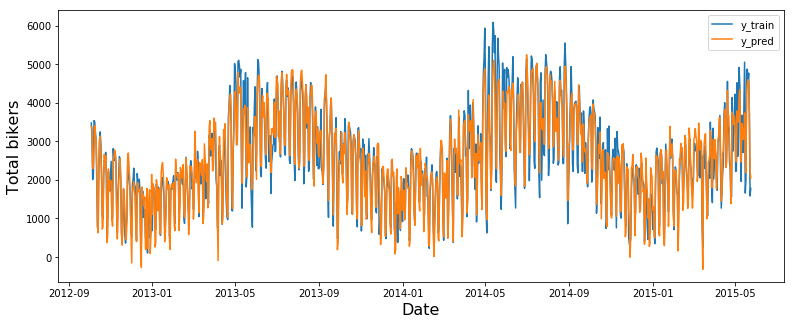

In [159]:
## Also, let's plot the current predictions to see if any patterns pop out.

# y_train contains date information, whereas y_pred does not.
# In order to plot both, I'll combine them into a new dataframe.
bikes = pd.DataFrame(y_train).rename(columns={'Total':'y_train'})
bikes['y_pred'] = y_pred

# And plot
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(bikes['y_train']);
ax.plot(bikes['y_pred']);
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Total bikers', fontsize=16)
ax.legend();

In [160]:
# Actually, it would be handy to have all the original variables in this dataset also, so I
# can plot a few things against each other.  Let's add them all together
bikes = bikes.join(X_train)

# And with all of this, let's calculate the current residuals
bikes['error'] = bikes['y_pred'] - bikes['y_train']
bikes.head(2)

,y_train,y_pred,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,...,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,error
2012-10-04,3475.0,3388.310452,0.0,0,0,18.9,8.3,65,3521.0,0.0,...,1.0,0.0,0.0,0.0,0.0,11.219142,13.6,1,0.00000,-86.689548
2012-10-05,3148.0,3337.818676,0.0,0,0,21.7,8.9,57,3475.0,0.0,...,0.0,1.0,0.0,0.0,0.0,11.161038,15.3,1,0.00274,189.818676


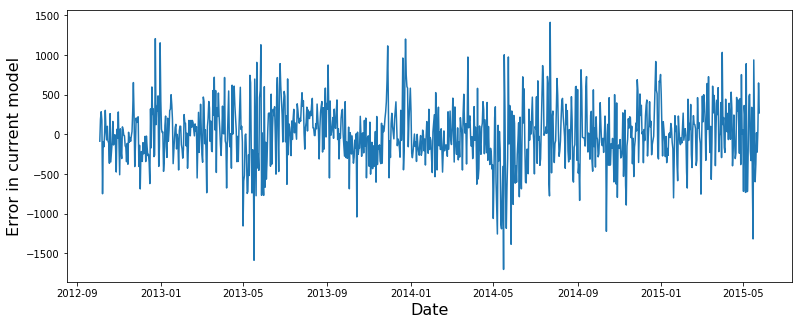

In [161]:
# Now, for example, I can see where in the time series the model messes up the most
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(bikes['error']);
ax.set_xlabel('Date', fontsize=16);
ax.set_ylabel('Error in current model', fontsize=16);

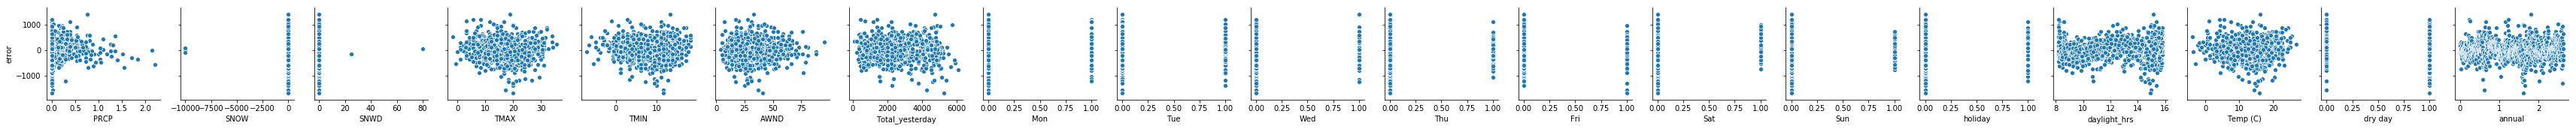

In [162]:
# And I can look for correlations between existing variables and the errors
sns.pairplot(data=bikes, y_vars=['error'], x_vars=X_train.columns);

In [163]:
# What the hell?  Why are there super-negative values of SNOW?
bikes.describe()

,y_train,y_pred,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,...,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,error
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,...,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,9.630000e+02
mean,2534.329180,2534.329180,0.123576,-41.390447,0.109034,15.673209,7.830737,31.888889,2536.141225,0.142264,...,0.143302,0.143302,0.143302,0.143302,0.028037,11.677381,11.751973,0.554517,1.317808,2.927761e-13
std,1224.065027,1159.027553,0.264611,643.435674,2.700110,6.994807,4.914016,14.643764,1224.232861,0.349502,...,0.350563,0.350563,0.350563,0.350563,0.165165,2.568741,5.756242,0.497277,0.762023,3.825744e+02
min,98.000000,-328.206743,0.000000,-9999.000000,0.000000,-1.600000,-7.100000,4.000000,98.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.218894,-3.800000,0.000000,0.000000,-1.702875e+03
25%,1755.000000,1778.701177,0.000000,0.000000,0.000000,10.600000,4.400000,22.000000,1755.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.206870,7.750000,0.000000,0.658904,-2.243506e+02
50%,2381.000000,2521.802871,0.000000,0.000000,0.000000,14.400000,7.800000,29.000000,2381.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.364878,10.850000,1.000000,1.317808,2.625797e+00
75%,3317.500000,3304.536271,0.129921,0.000000,0.000000,20.600000,11.700000,41.000000,3325.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,14.118901,16.375000,1.000000,1.976712,2.320792e+02
max,6088.000000,5243.561012,2.200787,74.000000,80.000000,35.600000,18.300000,95.000000,6088.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,15.781095,26.700000,1.000000,2.635616,1.410691e+03


That's right, I'd forgotten that SNOW had a few values set to -9999 that haven't been corrected yet.  In the graphs above I notice that, and also that there's an annual pattern to some of the mistakes. I think I could improve the results by adding a variable for particular months of the year, much like we added one for days earlier.

In [181]:
# Let's add binary columns that indicate the month:
months = ['January', 'February', 'March','April', 'May', 'June', 'July',
        'August', 'September','October', 'November', 'December']
for mon in months:
    bikes[mon] = (bikes.index.month_name() == mon).astype(float)

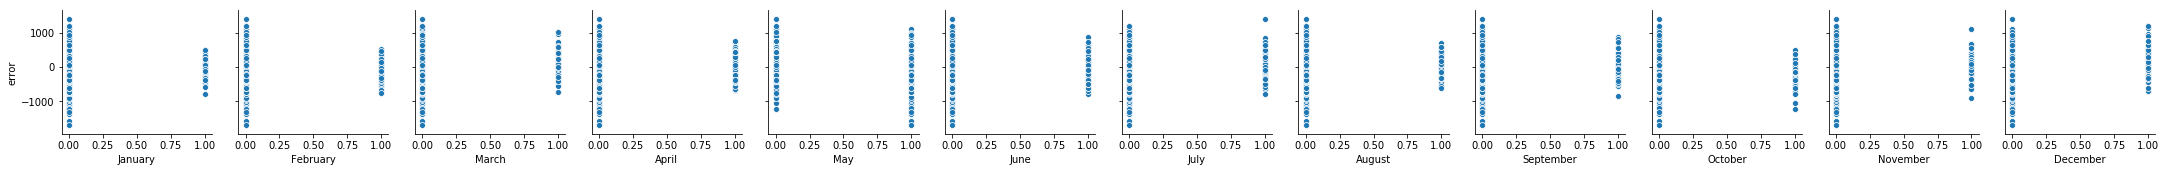

In [183]:
sns.pairplot(data=bikes, y_vars=['error'], x_vars=months);

These plots reflect the earlier idea that the model is underestimating the amount of biking in May, and overestimating it in December/January.  Let's fix that problem with SNOW, add in the month columns, and see whether the model improves much.

In [188]:
X_train.SNOW.value_counts()

 0       955
-9999      4
 74        1
 28        1
 20        1
 15        1
Name: SNOW, dtype: int64

In [189]:
# Only 8 values, and half of them are crap?!  I'll just drop the whole column.
X_train = X_train.drop(columns='SNOW')
X_test = X_test.drop(columns='SNOW')
bikes = bikes.drop(columns='SNOW')

In [190]:
# Let's add month columns to X_train:
months = ['January', 'February', 'March','April', 'May', 'June', 'July',
        'August', 'September','October', 'November', 'December']
for mon in months:
    X_train[mon] = (X_train.index.month_name() == mon).astype(float)

In [193]:
X_train.head(1)

,PRCP,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,...,March,April,May,June,July,August,September,October,November,December
2012-10-04,0.0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Back to the model

In [194]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [195]:
# And use CV to calculate its mean score
scores = cross_validate(Ridge(alpha=1), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

scores['test_score'].mean()

-308.93237869413

Dammit.  The overall score went up even more. How about if I add a few of the interaction terms suggested by the author?

In [202]:
X_train['Temp*PRCP'] = X_train['Temp (C)']*X_train['PRCP']

In [203]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [206]:
# And use CV to calculate its mean score
scores = cross_validate(Ridge(alpha=1), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

scores['test_score'].mean()

-307.5415129430996

## Check the test data
Alright, I'll get rid of the month columns, apply all the same transformations to X_test, and check the final score of the model.

In [209]:
X_train = X_train.drop(columns=months)
X_train.columns

Index(['PRCP', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs',
       'Temp (C)', 'dry day', 'annual', 'Temp*PRCP'],
      dtype='object')

In [212]:
## Copied from above, applied to X_test

# patterns of use generally vary from day to day; 
# let's add binary columns that indicate the day of the week:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    X_test[day] = (X_test.index.dayofweek == i).astype(float)
    
# we might expect riders to behave differently on holidays; 
# let's add an indicator of this as well:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
X_test = X_test.join(pd.Series(1, index=holidays, name='holiday'))
X_test['holiday'].fillna(0, inplace=True)

# We also might suspect that the hours of daylight would affect 
# how many people ride; let's use the standard astronomical calculation 
# to add this information:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

X_test['daylight_hrs'] = list(map(hours_of_daylight, X_test.index))

# temperatures are in 1/10 deg C; convert to C
X_test['TMIN'] /= 10
X_test['TMAX'] /= 10

# We can also calcuate the average temperature.
X_test['Temp (C)'] = 0.5 * (X_test['TMIN'] + X_test['TMAX'])

# precip is in 1/10 mm; convert to inches
X_test['PRCP'] /= 254

# In addition to the inches of precipitation, let's add a flag that 
# indicates whether a day is dry (has zero precipitation):
X_test['dry day'] = (X_test['PRCP'] == 0).astype(int)

# Let's add a counter that increases from day 1, and measures how many 
# years have passed. This will let us measure any observed annual increase 
# or decrease in daily crossings:
X_test['annual'] = (X_test.index - X_test.index[0]).days / 365.

In [213]:
X_test['Temp*PRCP'] = X_test['Temp (C)']*X_test['PRCP']

### First, let's get one final read on the score for X_train

In [218]:
# Retrieve that model
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [219]:
# And use CV to calculate its mean score
scores = cross_validate(Ridge(alpha=1), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

scores['test_score'].mean()

-305.8820202963745

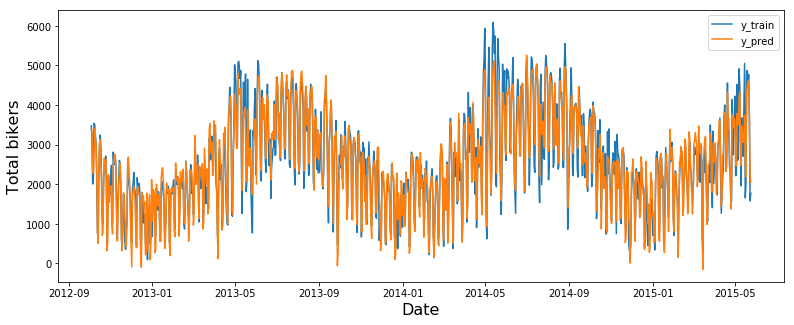

In [220]:
## Also, let's plot the current predictions to see if any patterns pop out.

# y_train contains date information, whereas y_pred does not.
# In order to plot both, I'll combine them into a new dataframe.
bikes = pd.DataFrame(y_train).rename(columns={'Total':'y_train'})
bikes['y_pred'] = y_pred

# And plot
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(bikes['y_train']);
ax.plot(bikes['y_pred']);
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Total bikers', fontsize=16)
ax.legend();

### Evalutate on X_test

In [221]:
# Retrieve that model
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

546.9099135738952

Huh, this error is actually much higher than it had been for the training data.  Can we see any discrepancies in the timeline plot?

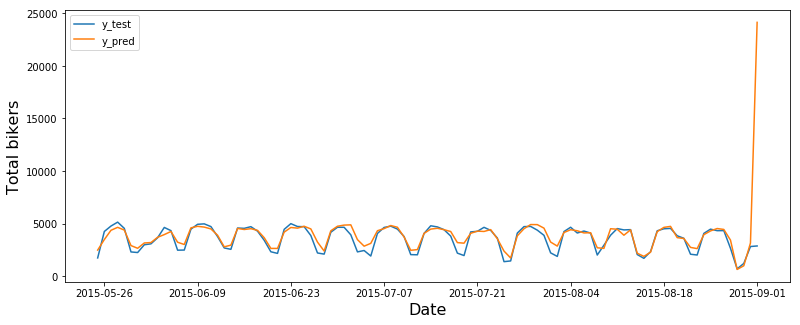

In [222]:
## Plotting...
bikes = pd.DataFrame(y_test).rename(columns={'Total':'y_test'})
bikes['y_pred'] = y_pred

# And plot
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(bikes['y_test']);
ax.plot(bikes['y_pred']);
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Total bikers', fontsize=16)
ax.legend();

WHAT THE HELL IS THAT SPIKE AT THE END?

In [223]:
X_test.describe()

,PRCP,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,Temp*PRCP
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.038307,0.0,26.443000,14.384000,-69.630000,3566.350000,0.15000,0.15000,0.140000,0.140000,0.140000,0.140000,0.140000,0.020000,15.038557,20.413500,0.870000,0.135616,0.667665
std,0.182073,0.0,4.277431,2.038108,1003.002288,1144.927463,0.35887,0.35887,0.348735,0.348735,0.348735,0.348735,0.348735,0.140705,0.776785,2.856102,0.337998,0.079484,3.154459
min,0.000000,0.0,15.600000,9.400000,-9999.000000,699.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.191795,13.350000,0.000000,0.000000,0.000000
25%,0.000000,0.0,23.750000,12.800000,24.000000,2330.500000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.514716,18.237500,1.000000,0.067808,0.000000
50%,0.000000,0.0,26.100000,14.400000,30.000000,4070.500000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.372409,20.250000,1.000000,0.135616,0.000000
75%,0.000000,0.0,29.400000,16.100000,35.000000,4513.500000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.672255,22.500000,1.000000,0.203425,0.000000
max,1.279528,0.0,35.000000,18.300000,58.000000,5142.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.781095,26.100000,1.000000,0.271233,22.711614


Looking closer at `X_test`, it seems that the AWND column has at least one value of `-9999`.  I had searched for these in `X_train` before, but I failed to also search in `X_test`.  Let this serve as a lesson.  Whenever we find strange data like this that can cause silent errors, *we have to search in all of our data, not just the subset that we were working with.*

In [231]:

X_test.AWND.value_counts()

 26      9
 30      8
 34      8
 24      6
 21      6
 35      5
 37      5
 27      4
 22      4
 32      4
 39      3
 23      3
 43      3
 19      3
 33      3
 25      3
 31      3
 18      2
 58      2
 28      2
 29      2
 38      2
 47      2
 52      1
 36      1
 42      1
 44      1
 20      1
 50      1
 17      1
-9999    1
Name: AWND, dtype: int64

In [227]:
# In fact, it's in the very last row of the dataset.
X_test.tail()

,PRCP,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,Temp*PRCP
2015-08-28,0.019685,0,23.3,15.6,26,4336.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.418591,19.45,0,0.260274,0.382874
2015-08-29,1.279528,0,22.2,13.3,58,2653.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.362212,17.75,0,0.263014,22.711614
2015-08-30,0.401575,0,20.0,12.8,47,699.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.305611,16.40,0,0.265753,6.585827
2015-08-31,0.000000,0,18.9,16.1,58,1213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.248802,17.50,1,0.268493,0.000000
2015-09-01,0.228346,0,19.4,13.9,-9999,2823.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.191795,16.65,0,0.271233,3.801969


In [241]:
# I'll replace with NANs throughout the dataset, to make sure 
# there are no others
X_test = X_test.replace(-9999, np.nan)
X_test.isnull().sum()

PRCP               0
SNWD               0
TMAX               0
TMIN               0
AWND               1
Total_yesterday    0
Mon                0
Tue                0
Wed                0
Thu                0
Fri                0
Sat                0
Sun                0
holiday            0
daylight_hrs       0
Temp (C)           0
dry day            0
annual             0
Temp*PRCP          0
dtype: int64

In [242]:
# Just to be sure, are there any left in X_train?
X_train = X_train.replace(-9999, np.nan)
X_train.isnull().sum()

PRCP               0
SNWD               0
TMAX               0
TMIN               0
AWND               0
Total_yesterday    0
Mon                0
Tue                0
Wed                0
Thu                0
Fri                0
Sat                0
Sun                0
holiday            0
daylight_hrs       0
Temp (C)           0
dry day            0
annual             0
Temp*PRCP          0
dtype: int64

In [248]:
# OK, we're clear.  Let's remove this last line and try again.
X_test = X_test.iloc[:-1]
y_test = y_test.iloc[:-1]

In [249]:
# Retrieve that model
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

337.6795817621051

Much better.

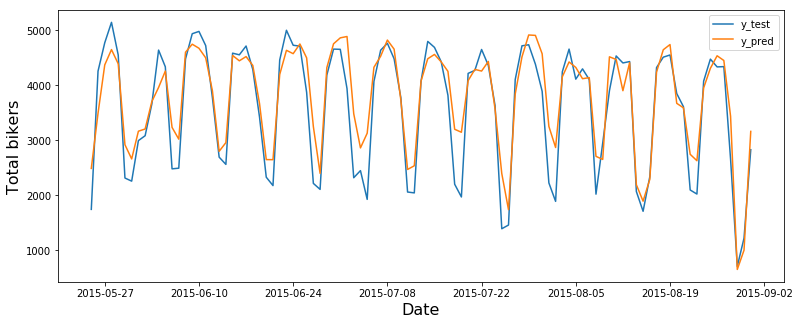

In [250]:
## Plotting...
bikes = pd.DataFrame(y_test).rename(columns={'Total':'y_test'})
bikes['y_pred'] = y_pred

# And plot
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(bikes['y_test']);
ax.plot(bikes['y_pred']);
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Total bikers', fontsize=16)
ax.legend();

And that's all, folks!